3. Compare o desempenho obtido considerando diferentes linguages. Por exemplo, indicando qual das linguagens tiram melhor partido do PowerCap.

Analizar a relação Package(PowerConsumption+Memory) e Time (Execution Time) em cada PowerLimit. As que tem melhor relação (Power Consumption Baixo e Execution Time Baixo) são melhores.

In [35]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as py
from sklearn.neighbors import KernelDensity
from scipy.stats import anderson
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

   Program  PowerLimit    Package       Core  Time  Temperature  Memory
0   avrora          -1  95.388550  86.098938  3352         50.4  118288
1   avrora          -1  95.057007  86.035278  3305         51.4  111336
2   avrora          -1  94.785522  85.811951  3234         53.0  108760
3   avrora          -1  97.049316  87.412903  3406         54.8  106288
4   avrora          -1  97.835144  87.864502  3427         54.5  116404


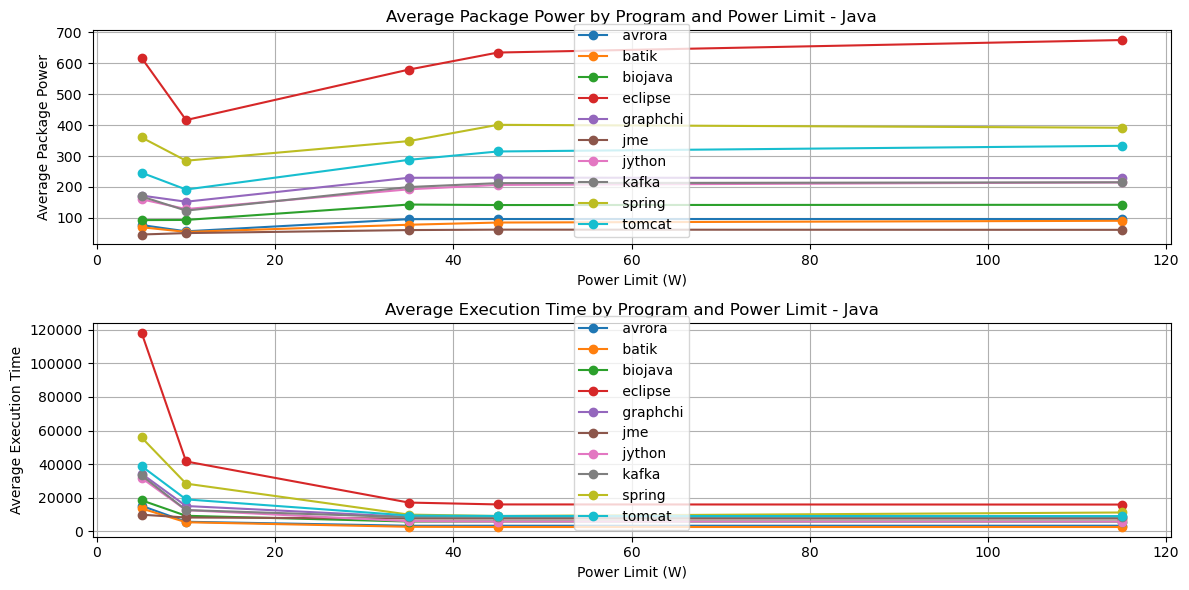

In [36]:
# Load the data from the CSV file
data_Java = pd.read_csv('measurements_java.csv')

# Display the first few rows of the Data_Javadata_JavaFrame

data_Java = data_Java.drop(['Language','DRAM', 'GPU'], axis=1)
print(data_Java.head())
# Ensure the 'Package' and 'Time' columns are numeric, converting any non-numeric values to NaN
#data_Java['Package'] = pd.to_numeric(data_Java['Package'], errors='coerce')
data_Java['PowerLimit'] = pd.to_numeric(data_Java['PowerLimit'], errors='coerce')
data_Java['Time'] = pd.to_numeric(data_Java['Time'], errors='coerce')

# Drop rows with NaN values in 'Package', 'Program', 'PowerLimit', or 'Time' columns
data_Java = data_Java.dropna(subset=[ 'Program', 'PowerLimit', 'Time'])

# Remove potential duplicates
data_Java = data_Java.drop_duplicates()

data_Java = data_Java[data_Java['PowerLimit'] != -1]
data_Java = data_Java[data_Java['Core'] > 0]
data_Java = data_Java[data_Java['Package'] > 0]

# Ensure that 'Program' is treated as a categorical variable
data_Java['Program'] = data_Java['Program'].astype('category')

# Group by 'Program' and 'PowerLimit' and calculate the mean package power and mean execution time
grouped_data_Java = data_Java.groupby(['Program', 'PowerLimit']).agg({
    'Package': 'mean',
    'Time': 'mean'
}).reset_index()

# Plotting the data_Java
plt.figure(figsize=(12, 6))

# Plot average package power by program and power limit
plt.subplot(2, 1, 1)
for program in grouped_data_Java['Program'].unique():
    subset = grouped_data_Java[grouped_data_Java['Program'] == program]
    plt.plot(subset['PowerLimit'], subset['Package'], label=program, marker='o')

plt.title('Average Package Power by Program and Power Limit - Java')
plt.xlabel('Power Limit (W)')
plt.ylabel('Average Package Power')
plt.legend()
plt.grid(True)

# Plot average execution time by program and power limit
plt.subplot(2, 1, 2)
for program in grouped_data_Java['Program'].unique():
    subset = grouped_data_Java[grouped_data_Java['Program'] == program]
    plt.plot(subset['PowerLimit'], subset['Time'], label=program, marker='o')

plt.title('Average Execution Time by Program and Power Limit - Java')
plt.xlabel('Power Limit (W)')
plt.ylabel('Average Execution Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
data_Java.head()

,Program,PowerLimit,Package,Core,Time,Temperature,Memory
100,avrora,5,76.536926,37.369080,15203,40.0,113244
101,avrora,5,77.472900,37.521423,15359,40.2,115728
102,avrora,5,73.132080,36.912476,14438,40.2,110840
103,avrora,5,77.351196,37.686096,15363,40.1,107952
104,avrora,5,77.643066,37.669067,15393,40.9,116788


In [38]:
# REMOVE OUTLIERS IN EACH POWERLIMIT GROUP FOR EACH PROGRAM

grouped_df = data_Java.groupby(['Program', 'PowerLimit'])
def remove_outliers(group):
    # Remove outliers from 'Time' column
    Q1_time = group['Time'].quantile(0.25)
    Q3_time = group['Time'].quantile(0.75)
    IQR_time = Q3_time - Q1_time
    mask_time = (group['Time'] >= (Q1_time - 1.5 * IQR_time)) & (group['Time'] <= (Q3_time + 1.5 * IQR_time))

    # Remove outliers from 'Package' column
    Q1_package = group['Package'].quantile(0.25)
    Q3_package = group['Package'].quantile(0.75)
    IQR_package = Q3_package - Q1_package
    mask_package = (group['Package'] >= (Q1_package - 1.5 * IQR_package)) & (group['Package'] <= (Q3_package + 1.5 * IQR_package))

    # Combine the masks for both columns
    mask = mask_time & mask_package

    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
print(cleaned_df.groupby(['Program','PowerLimit']).count())


                      Package  Core  Time  Temperature  Memory
Program   PowerLimit                                          
 avrora   5                 9     9     9            9       9
          10                8     8     8            8       8
          35                9     9     9            9       9
          45               10    10    10           10      10
          115              10    10    10           10      10
 batik    5                10    10    10           10      10
          10               10    10    10           10      10
          35               10    10    10           10      10
          45                9     9     9            9       9
          115               8     8     8            8       8
 biojava  5                10    10    10           10      10
          10                9     9     9            9       9
          35               10    10    10           10      10
          45               10    10    10           10 

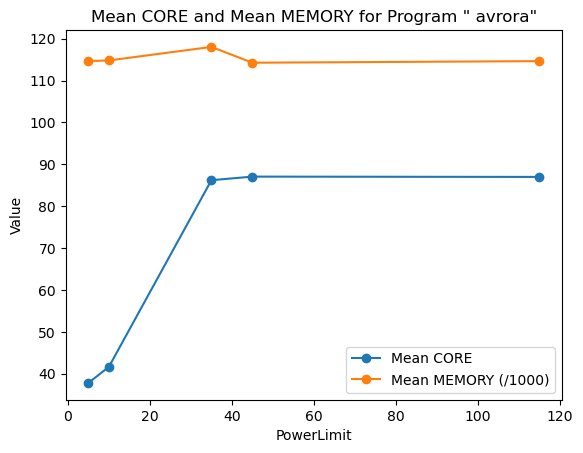

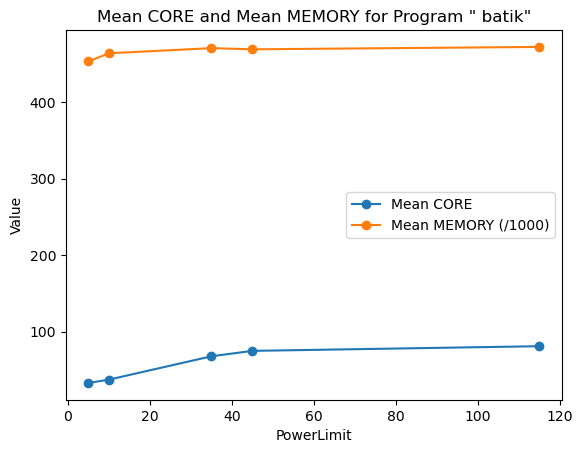

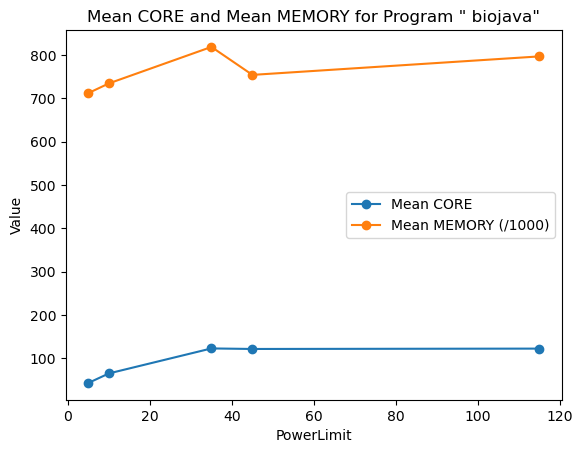

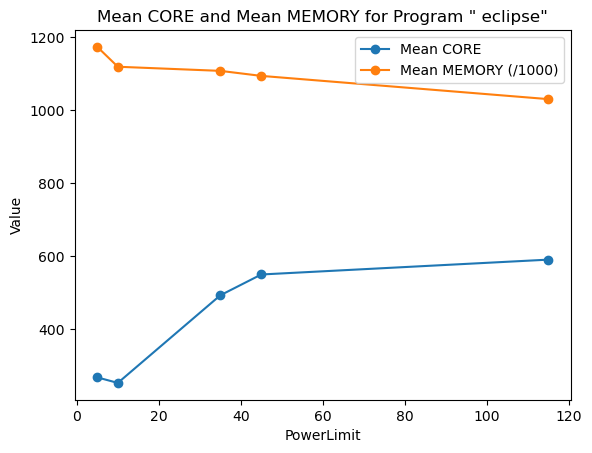

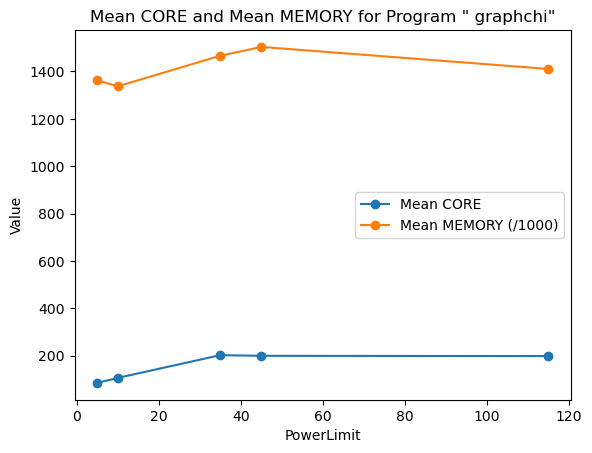

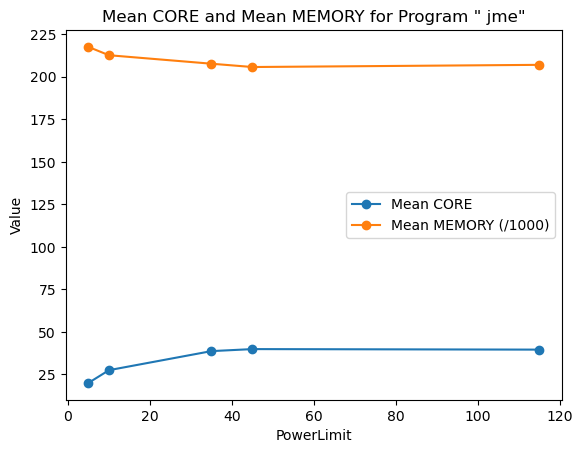

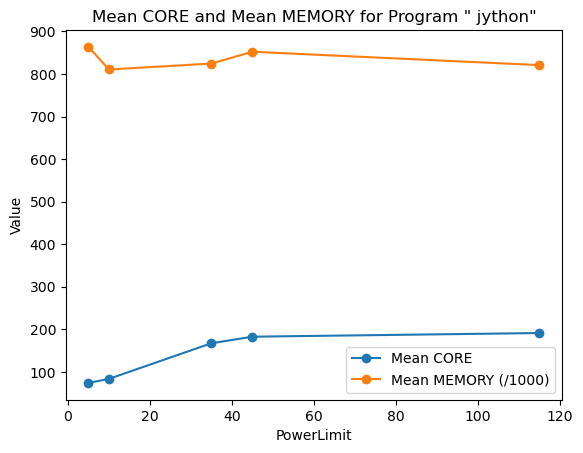

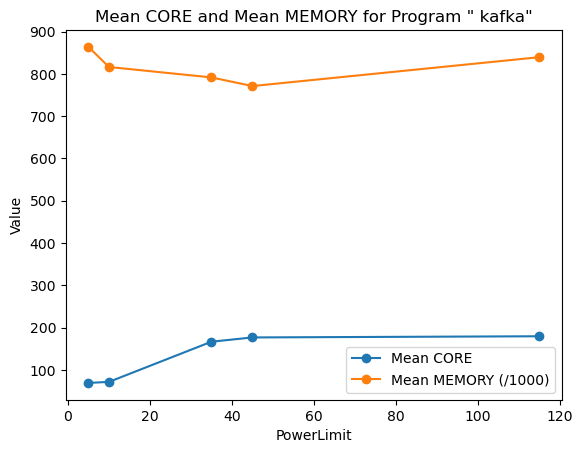

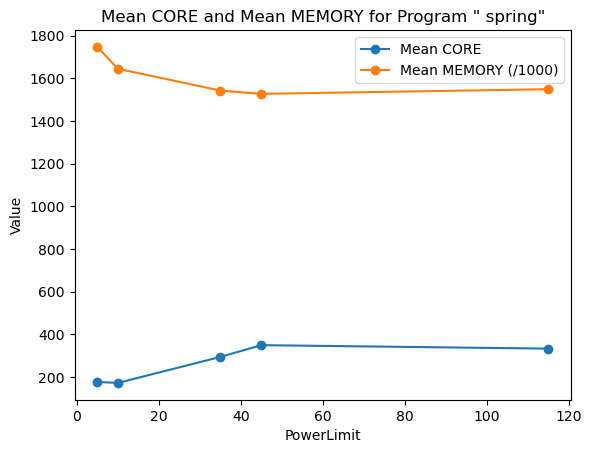

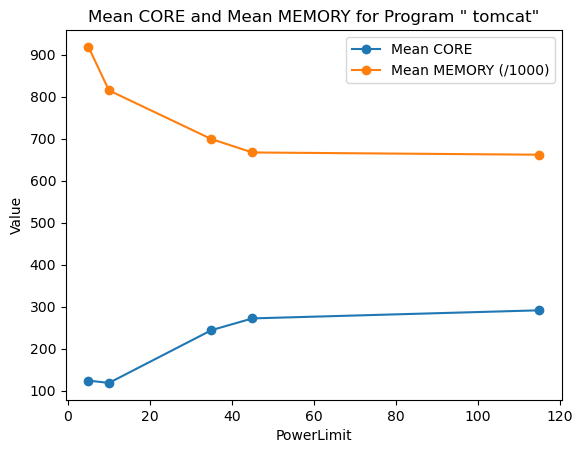

In [39]:
grouped = cleaned_df.groupby('Program')

def show_plot_Core_Memory(name, program_group):
    # Group the program group by PowerLimit
    power_groups = program_group.groupby('PowerLimit')

    # Create an empty list to store the data for each PowerLimit
    mean_core = []
    mean_memory = []

    # Extract data for each PowerLimit and store it in the list
    for power, power_group in power_groups:
        mean_core.append(power_group['Core'].mean())
        mean_memory.append(power_group['Memory'].mean()/1000)

    # Create a new figure for each program
    plt.figure()

    # Plot the mean CORE and mean MEMORY against PowerLimit
    plt.plot(power_groups.groups.keys(), mean_core, 'o-', label='Mean CORE')
    plt.plot(power_groups.groups.keys(), mean_memory, 'o-', label='Mean MEMORY (/1000)')

    # Set labels and title
    plt.xlabel('PowerLimit')
    plt.ylabel('Value')
    plt.title(f'Mean CORE and Mean MEMORY for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_plot function to each group
for name, program_group in grouped:
    show_plot_Core_Memory(name, program_group)

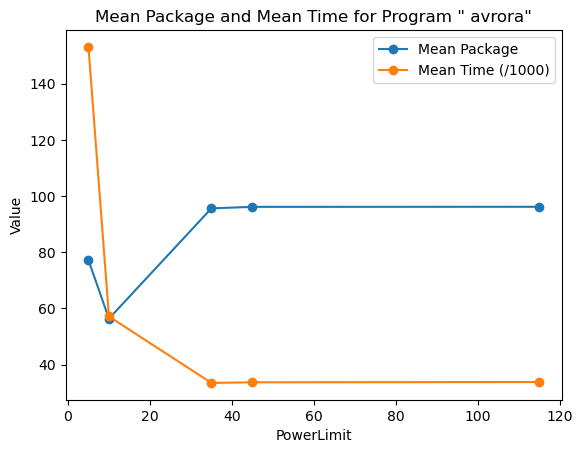

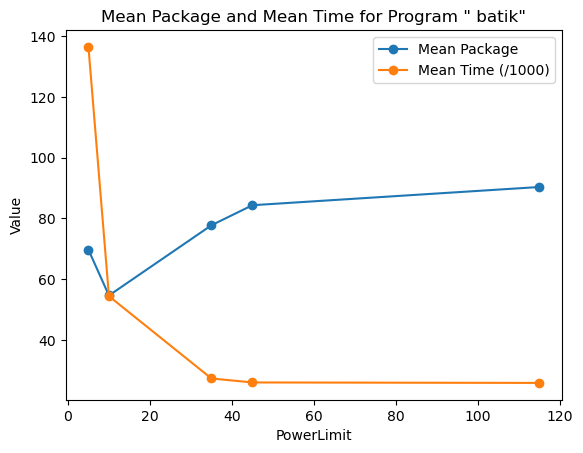

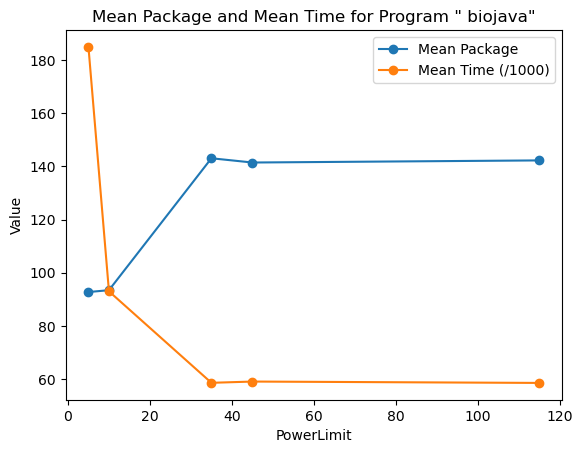

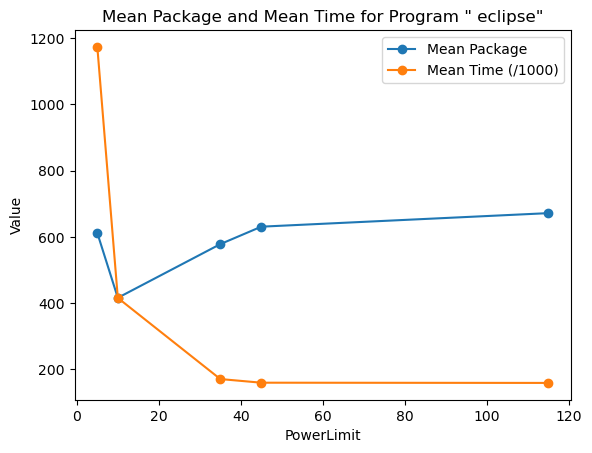

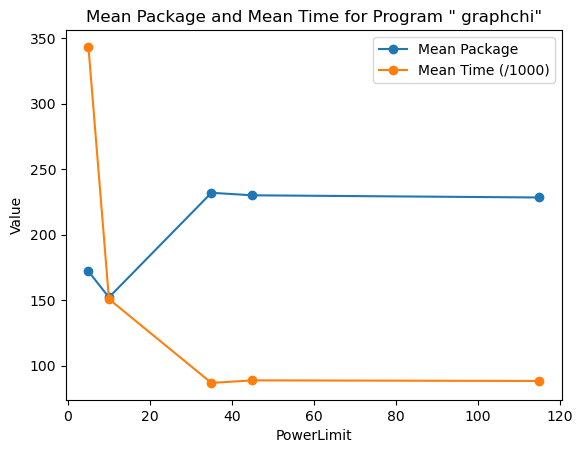

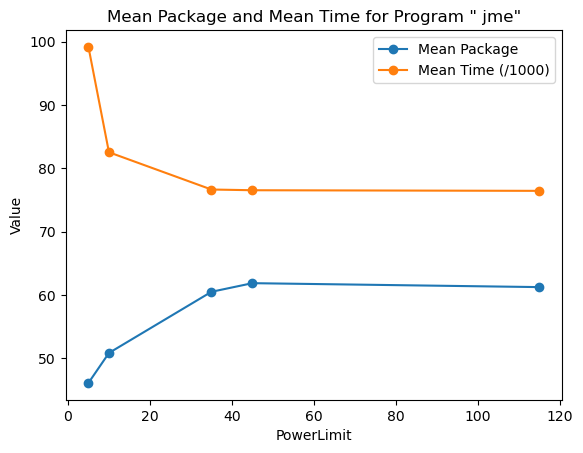

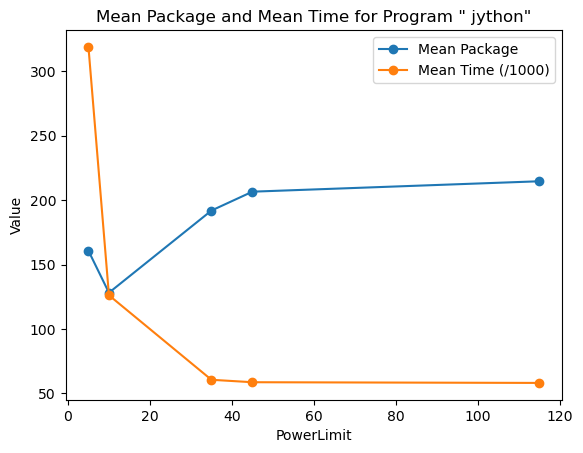

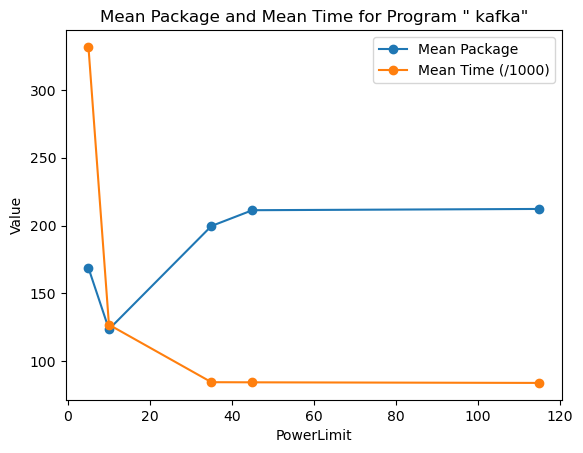

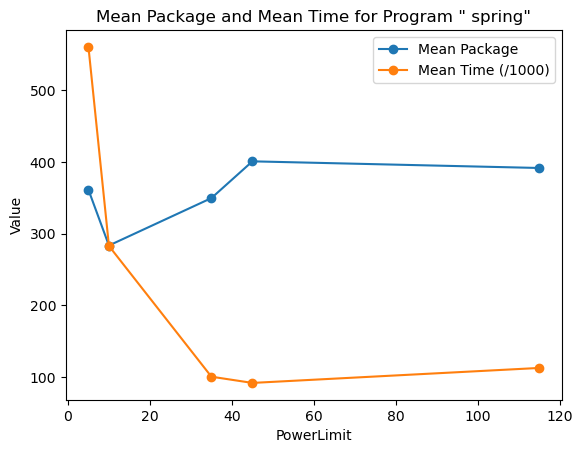

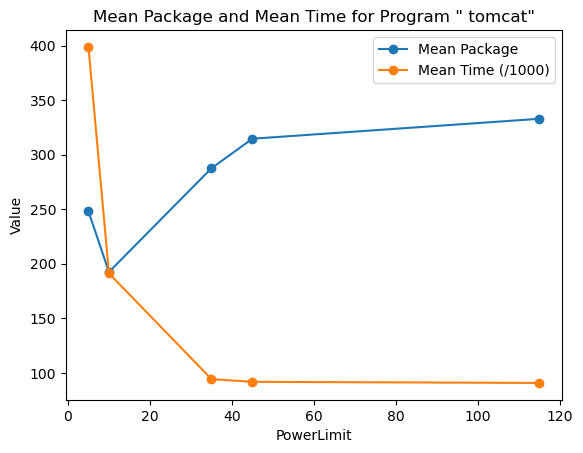

In [40]:
def show_plot_Package_Time(name, program_group):
    # Group the program group by PowerLimit
    power_groups = program_group.groupby('PowerLimit')

    # Create an empty list to store the data for each PowerLimit
    mean_package = []
    mean_time = []

    # Extract data for each PowerLimit and store it in the list
    for power, power_group in power_groups:
        mean_package.append(power_group['Package'].mean())
        mean_time.append(power_group['Time'].mean()/100)

    # Create a new figure for each program
    plt.figure()

    # Plot the mean CORE and mean MEMORY against PowerLimit
    plt.plot(power_groups.groups.keys(), mean_package, 'o-', label='Mean Package')
    plt.plot(power_groups.groups.keys(), mean_time, 'o-', label='Mean Time (/1000)')

    # Set labels and title
    plt.xlabel('PowerLimit')
    plt.ylabel('Value')
    plt.title(f'Mean Package and Mean Time for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_plot function to each group
for name, program_group in grouped:
    show_plot_Package_Time(name, program_group)

In [41]:
def show_stats(name, program_group):
    # Calculate the correlation coefficient between Time and Package
    corr_coef, p_value = stats.pearsonr(program_group['Time'], program_group['Package'])
    print(f"Program: {name}")
    print(f"Correlation coefficient between Time and Package: {corr_coef:.3f}")
    print(f"P-value: {p_value:.5f}")

    # Perform linear regression between Time and Package
    slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['Package'], program_group['Time'])
    print(f"Linear regression results:")
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.5f}")
    print(f"Standard error: {std_err:.3f}")
    print("-" * 30)

# Apply the show_stats function to each group
for name, program_group in grouped:
    show_stats(name, program_group)

Program:  avrora
Correlation coefficient between Time and Package: -0.442
P-value: 0.00209
Linear regression results:
Slope: -134.359
Intercept: 17585.144
R-squared: 0.196
P-value: 0.00209
Standard error: 41.081
------------------------------
Program:  batik
Correlation coefficient between Time and Package: -0.426
P-value: 0.00285
Linear regression results:
Slope: -149.052
Intercept: 16677.440
R-squared: 0.181
P-value: 0.00285
Standard error: 47.232
------------------------------
Program:  biojava
Correlation coefficient between Time and Package: -0.816
P-value: 0.00000
Linear regression results:
Slope: -167.510
Intercept: 29709.046
R-squared: 0.666
P-value: 0.00000
Standard error: 17.299
------------------------------
Program:  eclipse
Correlation coefficient between Time and Package: -0.103
P-value: 0.51208
Linear regression results:
Slope: -40.002
Intercept: 61692.337
R-squared: 0.011
P-value: 0.51208
Standard error: 60.485
------------------------------
Program:  graphchi
Correlati

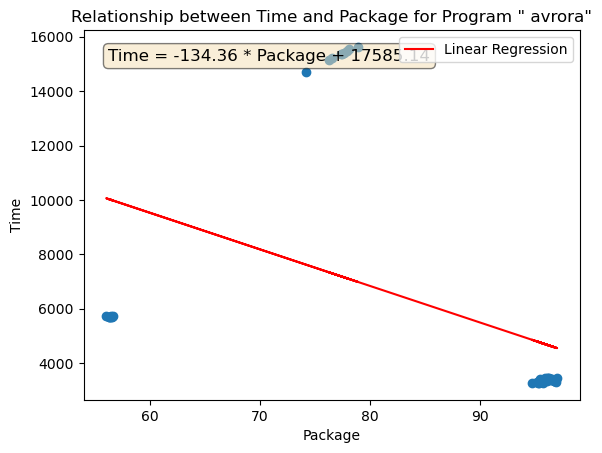

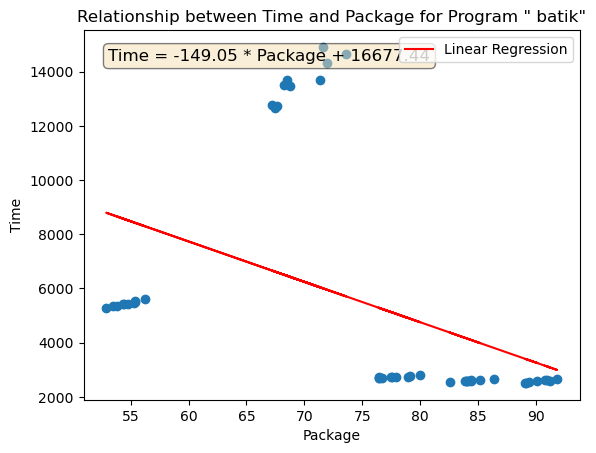

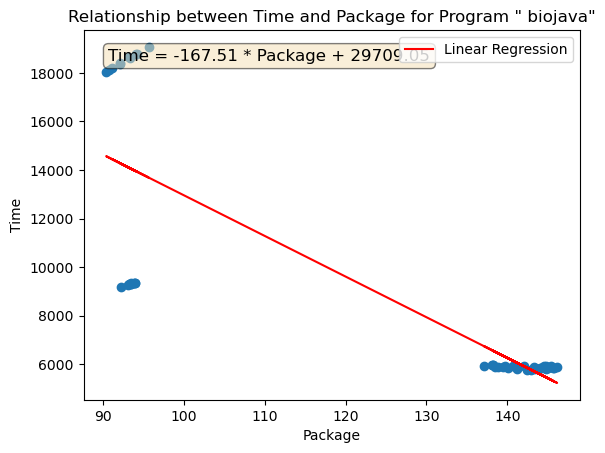

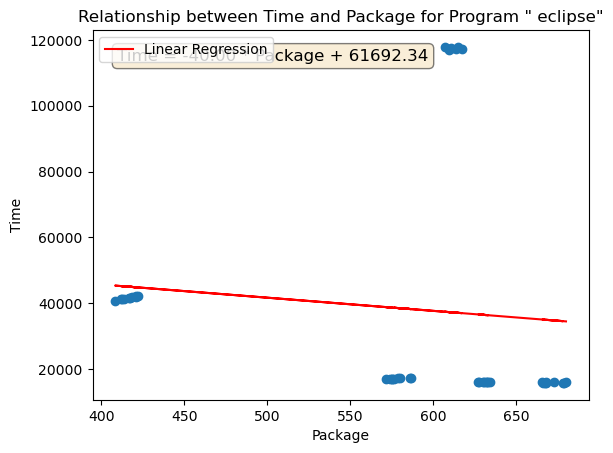

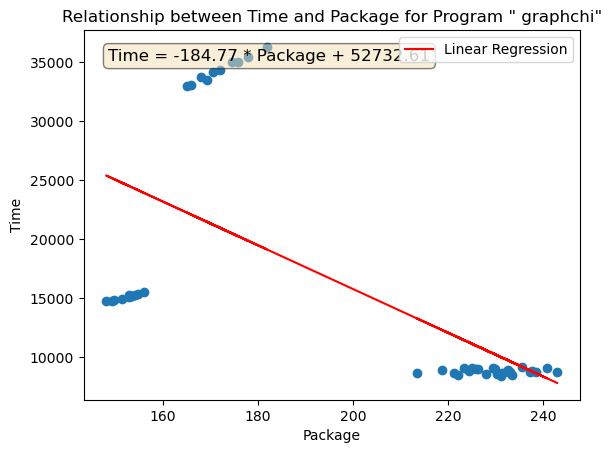

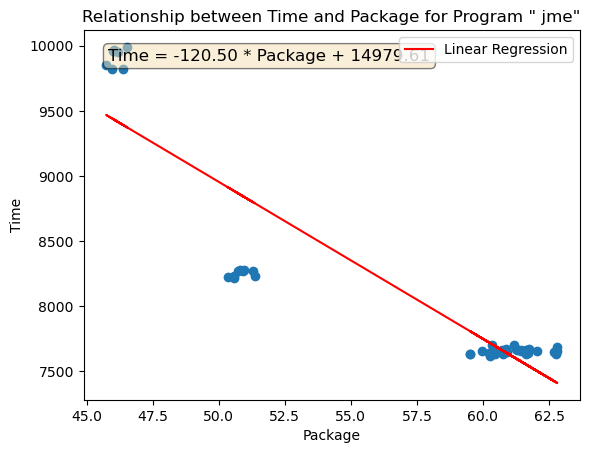

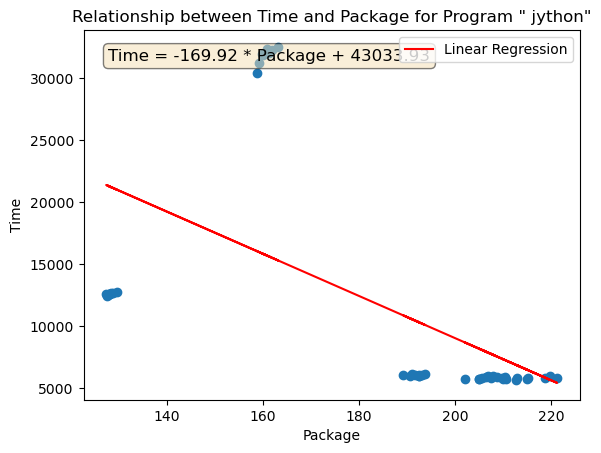

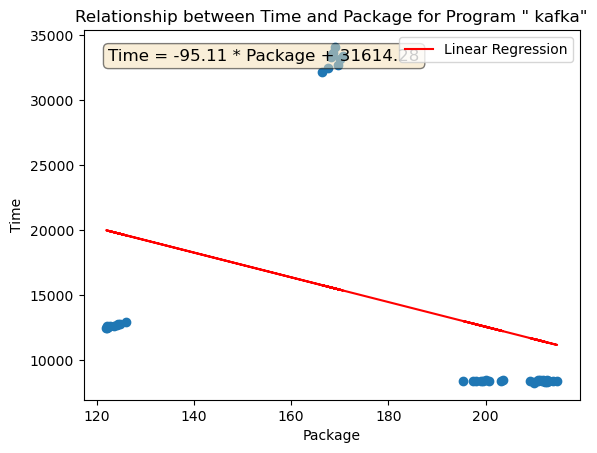

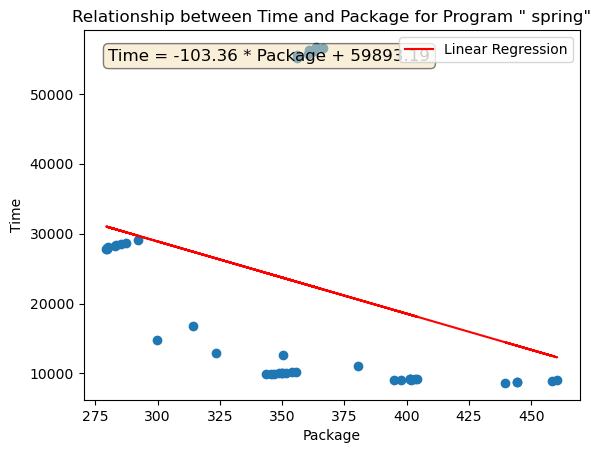

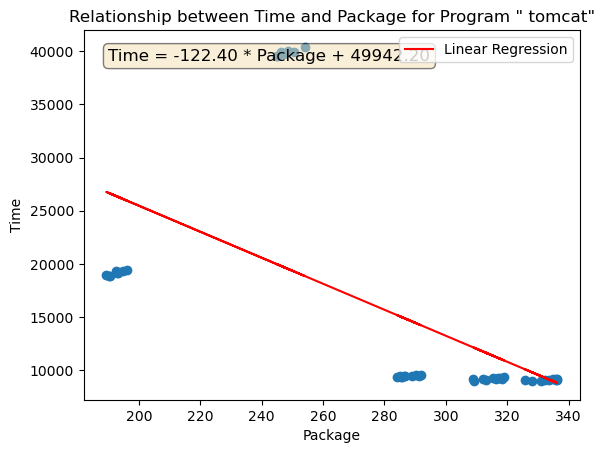

In [42]:
def show_scatter_plot(name, program_group):
    # Create a new figure for each program
    plt.figure()

    # Create a scatter plot of Time vs Package
    plt.scatter(program_group['Package'], program_group['Time'])

    # Perform linear regression between Time and Package
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])

    # Calculate the regression line
    x_values = program_group['Package']
    y_values = slope * x_values + intercept

    # Plot the regression line
    plt.plot(x_values, y_values, 'r', label='Linear Regression')

    # Display the regression equation
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Set labels and title
    plt.xlabel('Package')
    plt.ylabel('Time')
    plt.title(f'Relationship between Time and Package for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_scatter_plot function to each group
for name, program_group in grouped:
    show_scatter_plot(name, program_group)


In [43]:
regression_equations = {}
slope_vals = []
intercept_vals = []

for name, program_group in grouped:
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])
    slope_vals.append(slope)
    intercept_vals.append(intercept)
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    regression_equations[name] = equation

# Print the regression equations
for program, equation in regression_equations.items():
    print(f"Program: {program}")
    print(f"Regression equation: {equation}")
    print("-" * 30)

print("Average slope:", py.mean(slope_vals))
print("Average intercept:", py.mean(intercept_vals))

Program:  avrora
Regression equation: Time = -134.36 * Package + 17585.14
------------------------------
Program:  batik
Regression equation: Time = -149.05 * Package + 16677.44
------------------------------
Program:  biojava
Regression equation: Time = -167.51 * Package + 29709.05
------------------------------
Program:  eclipse
Regression equation: Time = -40.00 * Package + 61692.34
------------------------------
Program:  graphchi
Regression equation: Time = -184.77 * Package + 52732.61
------------------------------
Program:  jme
Regression equation: Time = -120.50 * Package + 14979.61
------------------------------
Program:  jython
Regression equation: Time = -169.92 * Package + 43033.93
------------------------------
Program:  kafka
Regression equation: Time = -95.11 * Package + 31614.28
------------------------------
Program:  spring
Regression equation: Time = -103.36 * Package + 59893.19
------------------------------
Program:  tomcat
Regression equation: Time = -122.40 * Pac

In [44]:
package_range = range(4, 7)

for program, equation in regression_equations.items():
    print(f"Program: {program}")
    for package in package_range:
        slope, intercept = equation.split(' = ')[1].split(' * Package + ')
        slope = float(slope)
        intercept = float(intercept)
        time = slope * package + intercept
        print(f"Package: {package}, Time: {time:.2f}")
    print("-" * 30)

Program:  avrora
Package: 4, Time: 17047.70
Package: 5, Time: 16913.34
Package: 6, Time: 16778.98
------------------------------
Program:  batik
Package: 4, Time: 16081.24
Package: 5, Time: 15932.19
Package: 6, Time: 15783.14
------------------------------
Program:  biojava
Package: 4, Time: 29039.01
Package: 5, Time: 28871.50
Package: 6, Time: 28703.99
------------------------------
Program:  eclipse
Package: 4, Time: 61532.34
Package: 5, Time: 61492.34
Package: 6, Time: 61452.34
------------------------------
Program:  graphchi
Package: 4, Time: 51993.53
Package: 5, Time: 51808.76
Package: 6, Time: 51623.99
------------------------------
Program:  jme
Package: 4, Time: 14497.61
Package: 5, Time: 14377.11
Package: 6, Time: 14256.61
------------------------------
Program:  jython
Package: 4, Time: 42354.25
Package: 5, Time: 42184.33
Package: 6, Time: 42014.41
------------------------------
Program:  kafka
Package: 4, Time: 31233.84
Package: 5, Time: 31138.73
Package: 6, Time: 31043.62


In [45]:
# Define a range of Package values to evaluate
package_range = range(4, 1550)

# Define weights for Time and Package
time_weight = 0.5
package_weight = 0.5

best_score = float('inf')
best_program = None
overall_scores = []

for program, equation in regression_equations.items():
    total_score = 0
    for package in package_range:
        slope, intercept = equation.split(' = ')[1].split(' * Package + ')
        slope = float(slope)
        intercept = float(intercept)
        time = max(slope * package + intercept, 0)
        score = time_weight * time + package_weight * package
        total_score += score
    
    average_score = total_score / len(package_range)
    overall_scores.append(average_score)
    
    if average_score < best_score:
        best_score = average_score
        best_program = program

    
    
    print(f"Program: {program}")
    print(f"Equation: {equation}")
    print(f"Average score: {average_score:.2f}")
    print("-" * 30)

print(f"The best program is: {best_program}")

overall_average_score = sum(overall_scores) / len(overall_scores)
print(f"\nOverall average score of Java Language: {overall_average_score:.2f}")

Program:  avrora
Equation: Time = -134.36 * Package + 17585.14
Average score: 740.79
------------------------------
Program:  batik
Equation: Time = -149.05 * Package + 16677.44
Average score: 671.42
------------------------------
Program:  biojava
Equation: Time = -167.51 * Package + 29709.05
Average score: 1207.01
------------------------------
Program:  eclipse
Equation: Time = -40.00 * Package + 61692.34
Average score: 15704.75
------------------------------
Program:  graphchi
Equation: Time = -184.77 * Package + 52732.61
Average score: 2762.57
------------------------------
Program:  jme
Equation: Time = -120.50 * Package + 14979.61
Average score: 672.66
------------------------------
Program:  jython
Equation: Time = -169.92 * Package + 43033.93
Average score: 2102.29
------------------------------
Program:  kafka
Equation: Time = -95.11 * Package + 31614.28
Average score: 2051.96
------------------------------
Program:  spring
Equation: Time = -103.36 * Package + 59893.19
Averag

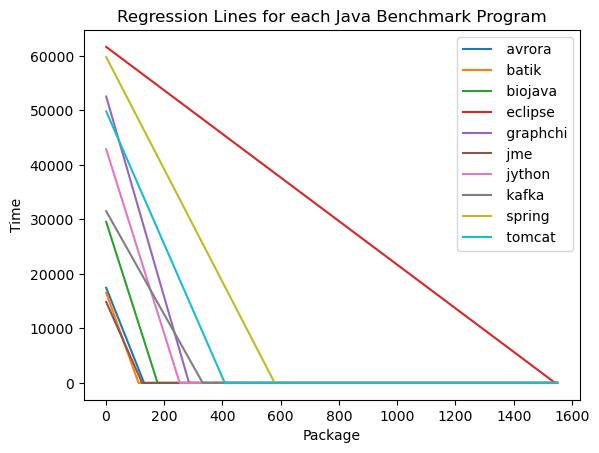

In [46]:
regression_equations = {}

# Create a figure and axis objects
fig, ax = plt.subplots()

# Define a range of Package values to evaluate
package_range = range(1, 1550)

for name, program_group in grouped:
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    regression_equations[name] = equation

    # Calculate the regression line
    x_values = package_range
    y_values = [max(slope * x + intercept, 0) for x in x_values]

    # Plot the regression line
    ax.plot(x_values, y_values, label=name)

# Set labels, title, and legend
ax.set_xlabel('Package')
ax.set_ylabel('Time')
ax.set_title('Regression Lines for each Java Benchmark Program')
ax.legend()

# Show the plot
plt.show()

## Conclusion

Java shows a good improvement in Execution Time when Powercap is increased. This means that per unit of powercap changed, there's a big diference in time. Statistically we can predict time with a linear regression equation , Time = slope * Package + interecept. 

The average slope and intercept across benchmarks is :

    - Average slope: -128.69811153642993
    - Average intercept: 37785.97711352551
  
The team created a custom score which takes into acount Time values and Package values, meaning a higher score the worst it is. 

The average score for haskell between 1-1550 in package values is 3547.35. 

